#**Gaussian Process Regression**
https://s3.amazonaws.com/rendezvouswithdestiny.me/finance/gp.html

Gaussian processes have in recent years found novel application in statistical analysis of a wide range of financial assets from stock prices to stock market volatility and also commodity spreads. In this short introduction, we review the theory of gaussian process regression with accompanying source implementation using Scipy/NumPy/Python.

##**Preliminaries**

A Gaussian Process is a natural generalization of the Gaussian Distribution to infinite dimensions. While a multi-variate Gaussian is specified by it's mean vector and covariance matrix,

$$\mathbf{x} \sim \mathcal{N}\left(\mathbf{\mu}, \mathbf{\Sigma}\right)$$

the Gaussian Process is determined by its mean function $m(x)$ and covariance function $k(x, x')$. So we write, 

$$
f(x) \sim \mathcal{GP}(m(x),k(x,x'))
$$
whereby 
$$
\begin{aligned}
m(x)&=\mathbb{E}[f(x)]\\
k(x,x')&=\text{cov}(f(x),f(x'))\\
&=\mathbb{E}[(f(x)-m(x))(f(x')-m(x'))]
\end{aligned}
$$

Imagine stretching the length of the vector $\mathbf{\mu}$ so that it contains more and more elements until eventually we have an infinite-sized collection. Effectively, we've turned the vector $\mathbf{\mu}$ into a function $m(x)$. Similarly, we have to resize the covariance matrix correspondingly to the same size as $\mathbf{\mu}$. We do this by extending the $n\times n$ covariance matrix into a $\infty\times \infty$ "matrix" - effectively obtaining a 2D covariance function $k(x, x')$.

With the above, it is then intuitively clear that while a multi-variate Gaussian specifies a **distribution over vectors**, the Gaussian Process is a **distribution over functions**.

A canonical example of a Gaussian Process is Brownian Motion $(B_t)_{t\ge0}$, which has,
$$
\begin{aligned}
\mathbb{E}[B_t]&=0\\
\text{cov}(B_s,B_t)&=\min(s,t)\\
\end{aligned}
$$

Formally, a Gaussian Process defines a distribution over functions $p(f)$ for $f: \Re\mapsto \Re$. Given this, it might seem at first that we would have to work with objects of infinite dimensions. Fortunately, the Gaussian nature of the whole setup means we only need to compute with objects of finite dimensions.

We know from standard results in the theory of multi-variate gaussian distributions that any subset of a multi-variate gaussian is also jointly gaussian distributed. The same applies to subsets of a Gaussian Process.

Suppose we sample the function $f$ at $n$ points indexed by $x_1,x_2,\ldots,x_n$ to get $\mathbf{f}=(f(x_1),f(x_2),\ldots f(x_n))$. Then $\mathbf{f}$ is a $n$-dimensional random vector which follows a multi-variate gaussian distribution.

One of the characterizations of a Gaussian Process $p(f)$ is that any finite subset $p(\mathbf{f})$ has a marginal distribution which follows a multi-variate gaussian distribution. Very often, we would assume that the mean function $m(x)=0$, which leaves us with the main task of specifying the covariance function (also known as the kernel) $k(x,x')$.

A common choice of kernel function is the <b><i>squared exponential</i></b> kernel,

$$
k_{SE}(x,x')=\text{exp}\left(-\frac{(x-x')^2}{2\sigma^2_l}\right)
$$<p>where $\sigma_l$ is a <b><i>hyperparameter</i></b> we need to specify during model selection.</p>
<p>We show below several classes of random functions drawn from a GP prior to illustrate the effects of the choice of $\sigma_l$ on the behavoir of the functions.</p>

In [0]:
from   functools import partial
import itertools
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.stats.correlation_tools import corr_nearest
import numpy as np
from   numpy.linalg import cholesky, det, eigvals, inv
from   numpy.random import multivariate_normal, normal
from   scipy import stats
from   scipy.optimize import fmin_cg, minimize
import scipy.optimize
from   statsmodels.stats.moment_helpers import corr2cov, cov2corr

%matplotlib inline  
np.set_printoptions( linewidth=1000 )

In [0]:
def kernel( x1, x2, a=1.0, sigma=5.):
    ''' squared exponential kernel '''
    return ( a ** 2 ) * np.exp( - ((x1-x2)**2 / (2*sigma**2)) )

def covariance_matrix( xs, cov_func=kernel ):
    ''' compute the covariance matrix given set of points '''
    xx, yy = np.meshgrid(xs, xs, sparse=True)
    cov_mat = cov_func( xx, yy )

    return cov_mat

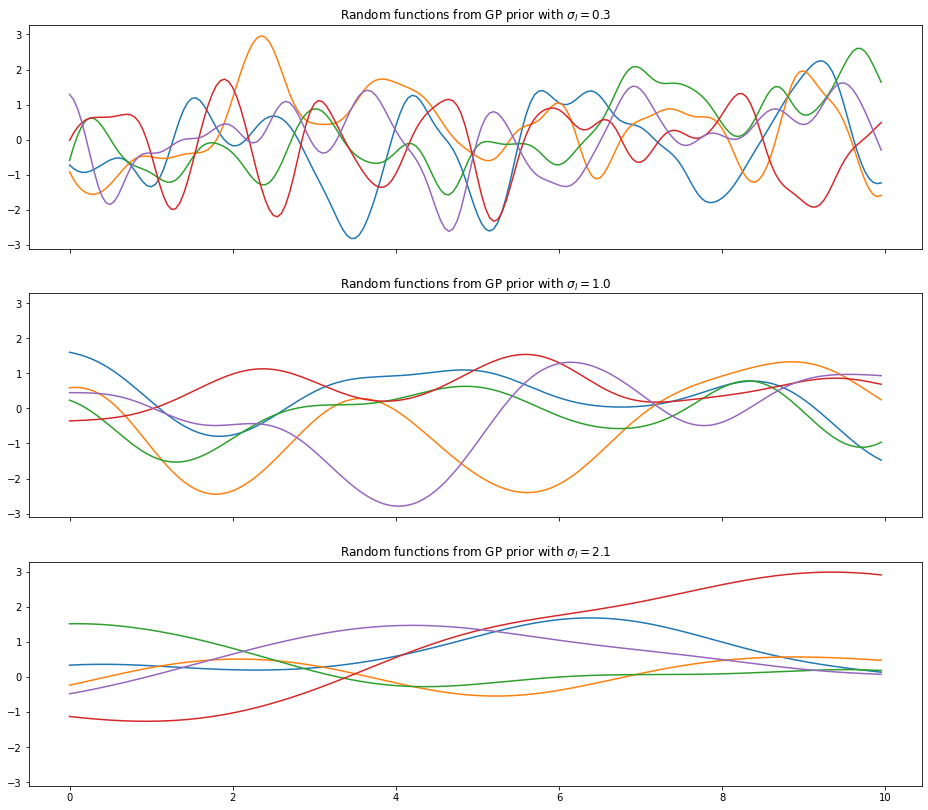

In [13]:
spacing = 0.05
xs = np.arange( 0.0, 10.0, spacing )
sigmas = [0.3, 1., 2.1]

f, axes = plt.subplots( 3, figsize=(16, 14), sharex=True, sharey=True )

for s, ax in zip( sigmas, axes ):
    cov_fn = partial( kernel, sigma=s )
    cov_mat = covariance_matrix(xs, cov_func = cov_fn )
    mean_vec = np.zeros( cov_mat.shape[0] )
    draws = multivariate_normal( mean_vec, cov_mat, 5 )
    for d in draws:
        ax.plot(xs,d)
        ax.set_title("Random functions from GP prior with $\sigma_l=%s$" % s)

As we can see from the above,  $\sigma_l$  is the characteristic length scale of the kernel, which controls the smoothness of the random functions drawn from the Gaussian Process.

##**Regression with Gaussian Processes**

Regression with Gaussian Processes proceeds via a Bayesian inference approach whereby we assume a suitable form of GP prior (with $m(x)=0$ for simplicity),
$$
f(x) \sim \mathcal{GP}(0,k(x,x'))
$$<p>Given the above prior, and together with a set of training data, we deduce the posterior distribution. Inference is then performed for a set of <b><i>test-inputs</i></b> using the posterior distribution to arrive at a predictive distribution conditional on the test-inputs and training data.</p>
<p>Let $\textbf{f}=[f(x_1), f(x_2), \ldots, f(x_N)]$ be the set of function values corresponding to the index points $\textbf{X}=(x_1, x_2, \ldots,x_N)$. Note that $\textbf{f}$ is a random variable and we make the distinction that $\textbf{y}=[y_1,y_2,\ldots,y_N]$ is a realization of $\textbf{f}$ for which we use to denote our training data. From our assumptions, their prior distribution is given by,</p>
$$
\textbf{f} \sim \mathcal{N}( \textbf{0}, K(\textbf{X}, \textbf{X}))
$$<p>which comes from our technical point previously that subsets of a GP follow a multivariate normal. In the above, the covariance matrix is denoted by $K(\textbf{X}, \textbf{X})$ where $K(\textbf{X}, \textbf{X})_{ij} = k_{SE}(x_i, x_j)$.</p>
<p>Now suppose we have a set of test-input points $\textbf{X}_{*}$, whose function values $\textbf{f}_{*}$ that we wish to infer. We know that $\textbf{f}$ and $\textbf{f}_{*}$ together follow a joint multivariate gaussian distribution and that writing them in this form is just a partitioning of it into two components. We can now write their prior distribution as,</p>
$$
\begin{bmatrix}
\textbf{f}_{\,}\\\textbf{f}_{*}
\end{bmatrix} \sim \mathcal{N} \left(\textbf{0},\begin{bmatrix}
K(\textbf{X}, \textbf{X}) & K(\textbf{X}, \textbf{X}_{*}) \\
K(\textbf{X}_{*}, \textbf{X}) & K(\textbf{X}_{*}, \textbf{X}_{*})
\end{bmatrix}\right) 
$$<p>From <a href="http://wwwf.imperial.ac.uk/~das01/MyWeb/M3S3/Handouts/MVN.pdf">standard results</a> on conditional distribution of multivariate gaussians, we know that $\textbf{f}_{*}$ conditional on $\textbf{f}=\textbf{y}$, $\textbf{X}$, $\textbf{X}_{*}$ follows the conditional distribution,</p>
$$
\textbf{f}_{*} \left|\,\textbf{f}=\textbf{y}, \textbf{X}, \textbf{X}_{*}\right. \sim \mathcal{N}\left( \textbf{$\mu$}^*,\mathbf{\Sigma}^*\right)
$$<p>where
$$
\begin{aligned}
\textbf{$\mu$}^* &= K(\textbf{X}_{*}, \textbf{X})K(\textbf{X}, \textbf{X})^{-1}\textbf{y}\\
\mathbf{\Sigma}^*&=K(\textbf{X}_{*}, \textbf{X}_{*}) - K(\textbf{X}_{*}, \textbf{X})K(\textbf{X}, \textbf{X})^{-1}K(\textbf{X}, \textbf{X}_{*})
 \end{aligned}
$$</p>
<p>We show in the below the Python code for the inference procedure for a single test input and a set of simulated training data.</p>

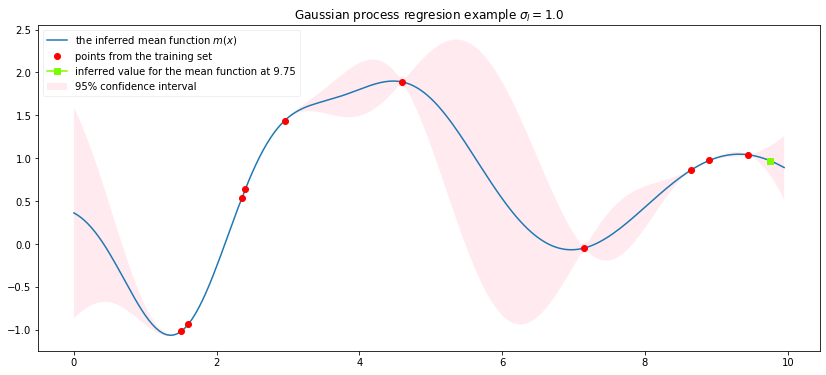

In [16]:
sigma  = 1.
trg_N  = 10 # choose a number random index points as "training data"
trg_xs = np.random.choice(xs[:int( 0.95 * len(xs))], trg_N, replace=False)
trg_xs.sort()
cov_mat  = covariance_matrix(trg_xs, cov_func = partial( kernel, sigma=sigma ) )
mean_vec = np.zeros( cov_mat.shape[0] )
y        = multivariate_normal( mean_vec, cov_mat, 1 ).T

Kxx_inv     = inv( cov_mat )
test_inp_xs = xs[ np.in1d( xs, trg_xs, invert=True ) ]
Kxsx        = kernel( *np.meshgrid(trg_xs, test_inp_xs), sigma=sigma )
mu_star     = Kxsx.dot(Kxx_inv.dot(y))

# compute the cov mat K(X*, X*) to graph the confidence intervals
Kxsxs       = kernel( *np.meshgrid(test_inp_xs, test_inp_xs), sigma=sigma )
sigma_star  = Kxsxs - Kxsx.dot( Kxx_inv.dot( Kxsx.T ) )
sigma_star_vars = np.diag( sigma_star )
intervals   = [ stats.norm.interval(0.95, m, np.sqrt(v)) for m, v in zip( mu_star.flatten(), sigma_star_vars ) ]
lower_intervals, upper_intervals = zip( *intervals )

# inference for single point
single_pt    = 9.75
single_pt_xs = np.array([single_pt])
Kxsx_single  = kernel( *np.meshgrid(trg_xs, single_pt_xs), sigma=sigma )
single_pt_y  = Kxsx_single.dot(Kxx_inv.dot(y))

f, ax = plt.subplots(figsize=(14, 6))
ax.plot( test_inp_xs, mu_star, label='the inferred mean function $m(x)$')
ax.plot( trg_xs, y, 'ro', label='points from the training set')
ax.plot( single_pt_xs, single_pt_y, color='lawngreen', marker='s', label='inferred value for the mean function at %s' % single_pt )

ax.fill_between( test_inp_xs, lower_intervals, upper_intervals, facecolor='pink', 
                 alpha=0.3, label='95% confidence interval')
ax.set_title('Gaussian process regresion example $\sigma_l=%s$' % sigma)
_ = plt.legend(framealpha=0.3, loc='upper left') 

In the graph above we plot the predicted mean function from the conditional distribution. The training data used for the inference procedure are the dots in red, and the single point whose value we want to infer is square in green. The envelops show the 95% confidence interval for the distribution of Gaussian Process.

We next show further draws of random functions from the conditional distribution used in the graph above (i.e. same set of training points).

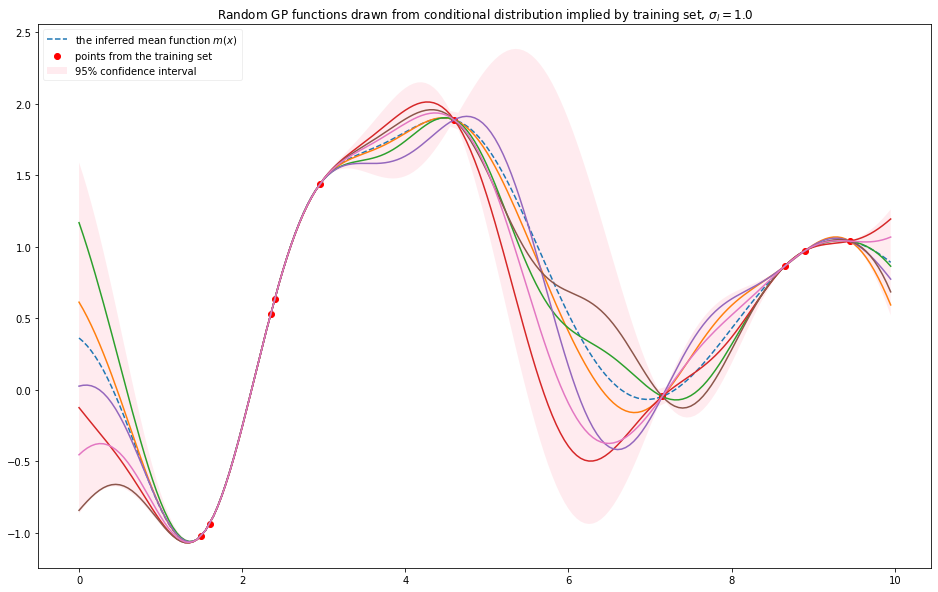

In [17]:
draws = multivariate_normal( mu_star.flatten(), sigma_star, 6 )
f, ax = plt.subplots(figsize=(16, 10))
ax.plot( test_inp_xs, mu_star, linestyle='--', label='the inferred mean function $m(x)$')
ax.plot( trg_xs, y, 'ro', label='points from the training set')
ax.fill_between( test_inp_xs, lower_intervals, upper_intervals, facecolor='pink', 
                 alpha=0.3, label='95% confidence interval')

ax.set_title('Random GP functions drawn from conditional distribution implied by training set, $\sigma_l=%s$'%sigma)
for draw in draws:
    ax.plot( test_inp_xs, draw, linestyle='-' )
_ = plt.legend(framealpha=0.3, loc='upper left' )

As we can see from the above graph, most of the random functions draw from the conditional distribution fall within the bounds of the confidence interval envelopes.

##**Hyperparameter Optimization**
With all the preliminaries in place, we next focus on the last missing piece after which we would be to put everything we've done so far to practical use.

When specifying the covariance kernel earlier, we had to specify the hyperparameter  σl . In practice, its value has to be learned from the training data as part of the hyperparameter optimization process. In this note, we focus on the technique of maximizing marginal log-likelihood for the optimization of our hyperparameters.

<p>Continuing with our earlier notation, we have the observed training set $\mathcal{D}=\{ (x_i,y_i)\}_{i=1}^N=(\mathbf{X},\mathbf{y})$, where $\mathbf{y}$ is a realization of the random variable $\mathbf{f}$. Given that $\textbf{f} \sim \mathcal{N}( \textbf{0}, K(\textbf{X}, \textbf{X}))$, we know that the likelihood of having observed the data is given by,</p>
$$
p\left(\,\mathbf{y}\left|\,\mathbf{X},\sigma_l \right.\right)=\frac{1}{2\pi^{\frac{N}{2}}\left|\mathbf{K}_{\sigma_l}\right|^\frac{1}{2}}\exp \left(-\frac{1}{2}\mathbf{y}^T\mathbf{K}_{\sigma_l}^{-1}\mathbf{y}\right)
$$<p>where we have abbreviated $\mathbf{K}_{\sigma_l} \equiv K(\textbf{X}, \textbf{X})$ to emphasize the dependence on the parameter $\sigma_l$ in the kernel function, which is what we are trying to optimize.</p>
<p>From the above, the log-likelihood is straightforward,</p>
$$
\log p\left(\,\mathbf{y}\left|\,\mathbf{X},\sigma_l \right.\right) = -\frac{N}{2}\log(2\pi)-\frac{1}{2}\log \left|\mathbf{K}_{\sigma_l}\right|-\frac{1}{2}\mathbf{y}^T\mathbf{K}_{\sigma_l}^{-1}\mathbf{y}
$$<p>To infer the hyperparameters via maximum likelihood, we need the partial derivatives of the log-likelihood function above,</p>
$$
\begin{aligned}
\frac{\partial}{\partial \sigma_l}\log p\left(\,\mathbf{y}\left|\,\mathbf{X},\sigma_l \right.\right) &= -\frac{\partial}{\partial \sigma_l}\frac{1}{2}\log \left|\mathbf{K}_{\sigma_l}\right| -\frac{\partial}{\partial \sigma_l} \frac{1}{2}\mathbf{y}^T\mathbf{K}_{\sigma_l}^{-1}\mathbf{y}\\
&= -\frac{1}{2}\text{tr}\left(\mathbf{K}_{\sigma_l}^{-1}\frac{\partial \mathbf{K}_{\sigma_l}}{\partial \sigma_l}\right) + \frac{1}{2}\underbrace{\mathbf{y}^T\mathbf{K}_{\sigma_l}^{-1}}_{\alpha^T} \frac{\partial \mathbf{K}_{\sigma_l}}{\partial \sigma_l} \underbrace{ \mathbf{K}_{\sigma_l}^{-1}\mathbf{y} }_{\alpha}\\
&=-\frac{1}{2}\text{tr}\left(\mathbf{K}_{\sigma_l}^{-1}\frac{\partial \mathbf{K}_{\sigma_l}}{\partial \sigma_l}\right)+\frac{1}{2}\alpha^T \frac{\partial \mathbf{K}_{\sigma_l}}{\partial \sigma_l} \alpha\\
&= \frac{1}{2}\text{tr}\left( \left(\alpha\alpha^T-\mathbf{K}_{\sigma_l}^{-1}\right)\frac{\partial \mathbf{K}_{\sigma_l}}{\partial \sigma_l}\right)
\end{aligned} 
$$<p>where in the above we have used the following identities,</p>
<ul>
<li>$\frac{\partial}{\partial \sigma_l}\mathbf{K}_{\sigma_l}^{-1}=-\mathbf{K}_{\sigma_l}^{-1}\frac{\partial \mathbf{K}_{\sigma_l}}{\partial \sigma_l} \mathbf{K}_{\sigma_l}^{-1}$</li>
<li>$\frac{\partial}{\partial \sigma_l}\log \left|\mathbf{K}_{\sigma_l}\right| =\text{tr}\left( \mathbf{K}_{\sigma_l}^{-1} \frac{\partial \mathbf{K}_{\sigma_l}}{\partial \sigma_l}\right)$</li>
<li>$\alpha^T \frac{\partial \mathbf{K}_{\sigma_l}}{\partial \sigma_l} \alpha = \text{tr}\left(\alpha\alpha^T\frac{\partial \mathbf{K}_{\sigma_l}}{\partial \sigma_l}\right)$</li>
</ul>
<p>Now that we have the partial derivatives of the log-likelihood function, we can apply gradient-based optimizers to the problem and to obtain the optimal value for $\sigma_l$. We show in the below data generated by choosing a particular value for $\sigma_l$, and then feed the data back into the maximum likelihood optimizer to see that we again get back a value close to what we've chosen.</p>
<p>We first compute the derivative of the kernel, 
$$
\begin{aligned}
\frac{\partial }{\partial \sigma_l}k_{SE}(x,x')&=\frac{\partial}{\partial \sigma_l}\text{exp}\left(-\frac{(x-x')^2}{2\sigma^2_l}\right)\\
&=\text{exp}\left(-\frac{(x-x')^2}{2\sigma^2_l}\right)\left(\frac{(x-x')^2}{\sigma_{l}^{3}}\right)
\end{aligned}
$$</p>
<p>We proceed to use the minimize suite of optimizers in scipy.optimize. The likelihood function we are maximizing is equivalent to minimizing the function (via it's gradient) below,</p>
$$
\begin{aligned}
f(\sigma_l) &= \log \left|\mathbf{K}_{\sigma_l}\right|+\mathbf{y}^T\mathbf{K}_{\sigma_l}^{-1}\mathbf{y}\\
f'(\sigma_l) &= \text{tr}\left( \left(\mathbf{K}_{\sigma_l}^{-1}-\alpha\alpha^T\right)\frac{\partial \mathbf{K}_{\sigma_l}}{\partial \sigma_l}\right)
\end{aligned}
$$<p>In the sample code, we generate a dummy data with $\sigma_l = 3.0$, and we show that the gradient descent optimizer correctly recovers the value we've used.</p>


In [26]:
def kernel_derivative( x1, x2, a=1.0, sigma=5.):
    ''' derivative of the squared exponential kernel wrt sigma '''
    return ( a ** 2 ) * np.exp( - (((x1-x2)**2) / (2*sigma**2)) ) * (((x1-x2)**2) / (sigma**3)) 

def log_likelihood( xs, ys, sigma ):
    ''' returns the value of the log-likelihood function given training set and sigma '''
    sigma = float(sigma)
    K = covariance_matrix(xs, cov_func = partial( kernel, sigma=sigma ) )
    det_K = det(K)
    inv_K = inv(K)
    
    res = np.log( det_K ) + ys.T.dot( inv_K.dot(ys) )[0][0]
    #print 'log_likelihood =', res, 'sigma =', sigma
    return res

def log_likelihood_derivative( xs, ys, sigma ):
    
    dK    = covariance_matrix(xs, cov_func = partial( kernel_derivative, sigma=sigma ) )
    inv_K = inv( covariance_matrix(xs, cov_func = partial( kernel, sigma=sigma ) ) )
    alpha = inv_K.dot( ys )
    ret   = np.trace( ( inv_K - alpha.dot(alpha.T) ).dot( dK ) )
    #print 'log_likelihood_derivative =', ret, 'sigma =', sigma
    return [ret]
    
# generate our training set with given values
spacing  = 1.0 # repeating this for clarity 
sigma    = 3.   # use new sigma of 3.0 and that's what we'll try to recover
trg_xs   = np.arange( 0.0, 20.0, spacing )
cov_mat  = covariance_matrix(trg_xs, cov_func = partial( kernel, sigma=sigma ) )
mean_vec = np.zeros( cov_mat.shape[0] )
y        = multivariate_normal( mean_vec, cov_mat, 1 ).T

# now we use gradient based optimizers to try and recover the sigma value used 
# via maximizing the likelihood function
f           = partial( log_likelihood, trg_xs, y )
gradf       = partial( log_likelihood_derivative, trg_xs, y )
initial_val = 1.

# maximum likelihood optimization
opt_result,_,_  = scipy.optimize.fmin_tnc( f, xs, fprime=gradf, bounds = [(0.8,3.3)], ftol=0.01 )
opt_result      = opt_result.flatten()
opt_result_fval = f( opt_result )

ss = np.arange( 1., 3.3, 0.01 )
fn_vals = map( f, ss )
gradfn_vals = map( gradf, ss )

# graph out the likelihood function and the derivative of the likelihood function, and the recovered sigma.
_, (ax1, ax2) = plt.subplots( 1, 2, figsize=(16, 4) )
ax1.plot( ss, fn_vals, color='pink', linewidth=2.0 )
ax1.plot( [opt_result], [opt_result_fval], 'ro' )
ax1.annotate('%.3f'%opt_result, (opt_result,opt_result_fval), xytext=(opt_result, opt_result_fval+5))
ax1.set_title("log-likelihood function")
ax2.plot( ss, gradfn_vals, color='orange', linewidth=2.0 )
_=ax2.set_title("derivative of log-likelihood function")

ValueError: ignored